<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-stocks" data-toc-modified-id="Loading-the-stocks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the stocks</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#We-plot-the-linear-regression-results:" data-toc-modified-id="We-plot-the-linear-regression-results:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>We plot the linear regression results:</a></span></li><li><span><a href="#RMSE-&amp;-Normalized-RMSE" data-toc-modified-id="RMSE-&amp;-Normalized-RMSE-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RMSE &amp; Normalized RMSE</a></span><ul class="toc-item"><li><span><a href="#RMSE" data-toc-modified-id="RMSE-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>RMSE</a></span></li><li><span><a href="#Normalized-RMSE" data-toc-modified-id="Normalized-RMSE-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Normalized RMSE</a></span></li></ul></li><li><span><a href="#Percent-of-good-prediction-of-up/down:" data-toc-modified-id="Percent-of-good-prediction-of-up/down:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Percent of good prediction of up/down:</a></span></li><li><span><a href="#Plot-how-much-we-won/lost:" data-toc-modified-id="Plot-how-much-we-won/lost:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plot how much we won/lost:</a></span></li><li><span><a href="#Print-how-much-we-made:" data-toc-modified-id="Print-how-much-we-made:-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Print how much we made:</a></span></li></ul></li></ul></div>

# AI Part

In [1]:
# cell for autoreload includes
%load_ext autoreload
%autoreload 2

## Loading the stocks

In [2]:
from src.stocks import Stocks
# The warnings are due to the includes in the file

22/06/21 20:47:58 WARN Utils: Your hostname, Mathieus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.25 instead (on interface en0)
22/06/21 20:47:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/21 20:47:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


We define the schema of the datas contained in files

In [3]:
from pyspark.sql.types import DoubleType, StringType, DateType, StructType, StructField

In [4]:
data_schema = StructType([
    StructField('Date', DateType(), True),
    StructField('High', DoubleType(), True),
    StructField('Low', DoubleType(), True),
    StructField('Open', DoubleType(), True),
    StructField('Close', DoubleType(), True),
    StructField('Volume', DoubleType(), True),
    StructField('Adj Close', DoubleType(), True),
    StructField('company_name', StringType(), True)
])

We load all the stocks:

In [5]:
stocks = Stocks(header=True, delimiter=',', schema=data_schema)

We show an exemple of stock with all the indicators:

In [6]:
stocks.stocks[0].predict.fullDF.show(4)

+----------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------+----------------+
|      Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|       next_Close|               CCI|               roc|       momentum|    R_de_williams|            BB_MM|            BB_UB|            BB_LB|            KB_MM|            KB_UB|            KB_LB|               DPO|                BOF|moving_average_Close|daily_return_day|
+----------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+-----------------+----

## Linear Regression

Using our estimators, we predict the next value of "Close":

In [7]:
stocks.call_prediction_function("print_linear_regression")

############################
########## GOOGLE ##########
############################

+-----------------+-----------------+
|       next_Close|  pred_next_Close|
+-----------------+-----------------+
|806.6500244140625|807.7372433807021|
|807.8800048828125|806.4197760812422|
|806.0700073242188|805.2244846034253|
|835.6699829101562|825.3460841706785|
| 798.530029296875|793.4885777163566|
|808.3800048828125|810.0321515938703|
|824.1599731445312|823.2118950260925|
| 829.280029296875|829.5207571034452|
|845.5399780273438| 846.317140663973|
|845.6199951171875|851.0022203355221|
|847.2000122070312|848.7647973047225|
|852.1199951171875|851.3266553680351|
|830.4600219726562|849.6607202991539|
| 819.510009765625|815.0408115372717|
|831.4099731445312| 835.072518744517|
|837.1699829101562|826.3675582816576|
|           874.25|870.2863826996321|
|964.8599853515625|975.3095206832935|
| 939.780029296875|941.8916345838812|
|957.0900268554688|960.2761425002304|
+-----------------+-----------------+


### We plot the linear regression results:

############################
########## GOOGLE ##########
############################



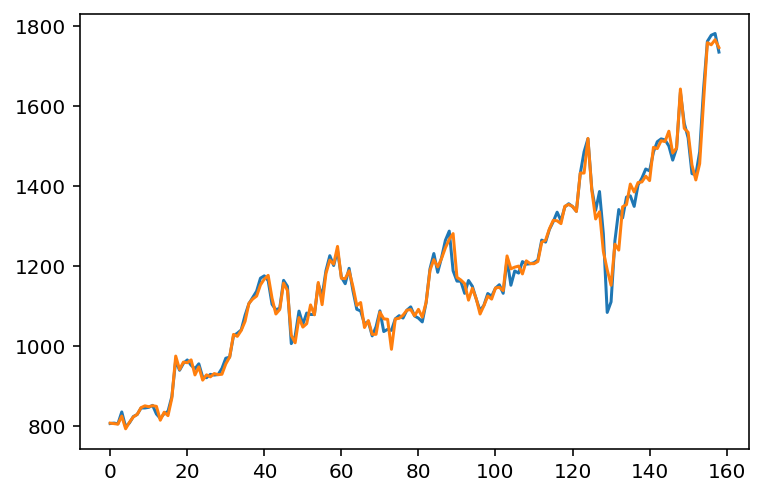

##############################
########## FACEBOOK ##########
##############################



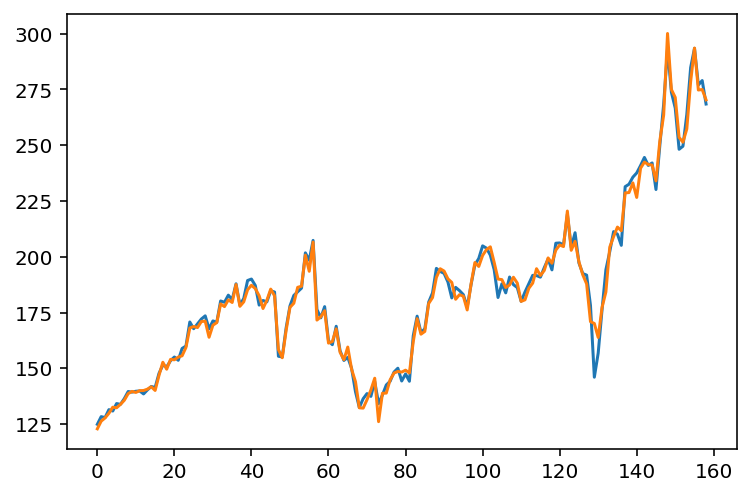

############################
########## AMAZON ##########
############################



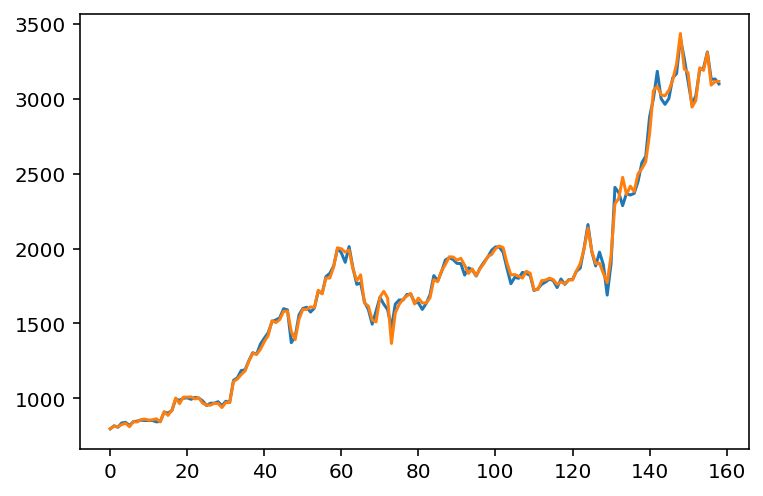

###########################
########## APPLE ##########
###########################



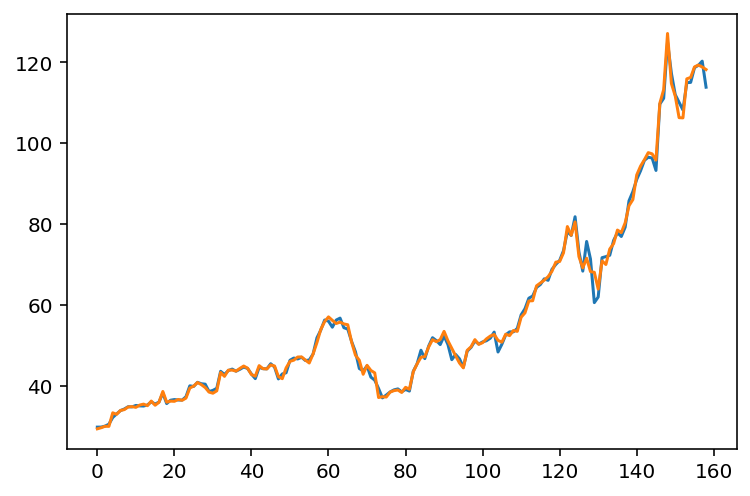

###########################
########## TESLA ##########
###########################



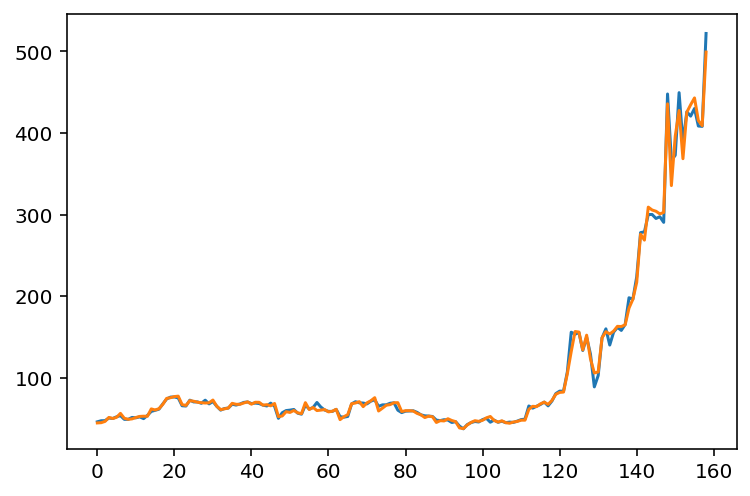

###############################
########## MICROSOFT ##########
###############################



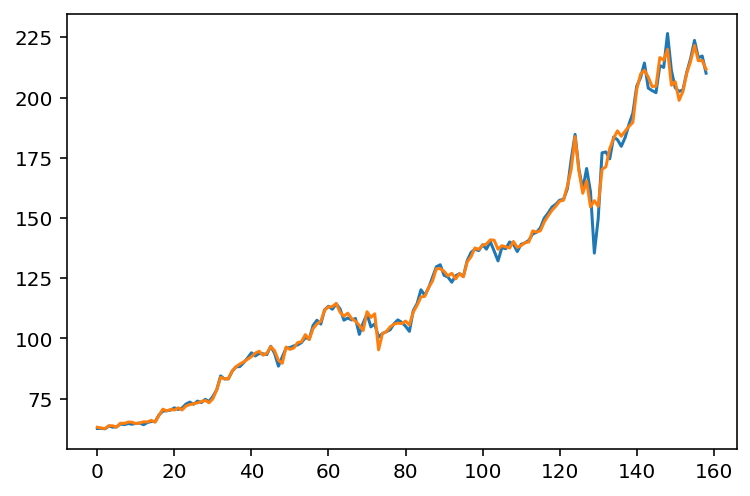

##########################
########## ZOOM ##########
##########################



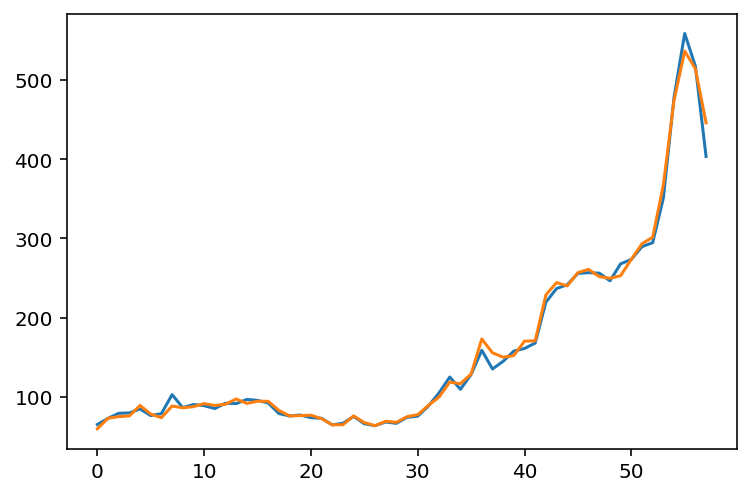

In [8]:
stocks.call_prediction_function("plot_linear_regression")

### RMSE & Normalized RMSE

#### RMSE

In [9]:
stocks.call_prediction_function("eval_rmse")

############################
########## GOOGLE ##########
############################

Metric name: rmse
Label Column: next_Close
Prediction column: pred_next_Close
RMSE value: 21.124714521573537


##############################
########## FACEBOOK ##########
##############################

Metric name: rmse
Label Column: next_Close
Prediction column: pred_next_Close
RMSE value: 3.597564992106485


############################
########## AMAZON ##########
############################

Metric name: rmse
Label Column: next_Close
Prediction column: pred_next_Close
RMSE value: 36.671478840627074


###########################
########## APPLE ##########
###########################

Metric name: rmse
Label Column: next_Close
Prediction column: pred_next_Close
RMSE value: 1.2454461811662891


###########################
########## TESLA ##########
###########################

Metric name: rmse
Label Column: next_Close
Prediction column: pred_next_Close
RMSE value: 6.037150195487233


#######

#### Normalized RMSE
for normalised RMSE, the lower the number the better!

formula: `Normalized RMSE = RMSE / (max value – min value)`

In [10]:
stocks.call_prediction_function("normalised_rmse")

############################
########## GOOGLE ##########
############################

Max Value: 1807.1199951171875
Min Value: 786.1400146484375
Normalised RMSE : 0.020690625600587004


##############################
########## FACEBOOK ##########
##############################

Max Value: 303.9100036621094
Min Value: 116.86000061035156
Normalised RMSE : 0.01923317259241647


############################
########## AMAZON ##########
############################

Max Value: 3531.449951171875
Min Value: 753.6699829101562
Normalised RMSE : 0.013201721972088156


###########################
########## APPLE ##########
###########################

Max Value: 134.17999267578125
Min Value: 29.0049991607666
Normalised RMSE : 0.011841656838214977


###########################
########## TESLA ##########
###########################

Max Value: 585.760009765625
Min Value: 35.79399871826172
Normalised RMSE : 0.010977315096236577


###############################
########## MICROSOFT ##########
#

### Percent of good prediction of up/down:

In [11]:
stocks.call_prediction_function("percent_good_up_down")

############################
########## GOOGLE ##########
############################

Percent of good prediction of UP/DOWN : 0.5849056603773585%
##############################
########## FACEBOOK ##########
##############################

Percent of good prediction of UP/DOWN : 0.5157232704402516%
############################
########## AMAZON ##########
############################

Percent of good prediction of UP/DOWN : 0.5974842767295597%
###########################
########## APPLE ##########
###########################

Percent of good prediction of UP/DOWN : 0.4716981132075472%
###########################
########## TESLA ##########
###########################

Percent of good prediction of UP/DOWN : 0.5723270440251572%
###############################
########## MICROSOFT ##########
###############################

Percent of good prediction of UP/DOWN : 0.5408805031446541%
##########################
########## ZOOM ##########
##########################

Percent of good predi

### Plot how much we won/lost:

############################
########## GOOGLE ##########
############################



<Figure size 2160x720 with 0 Axes>

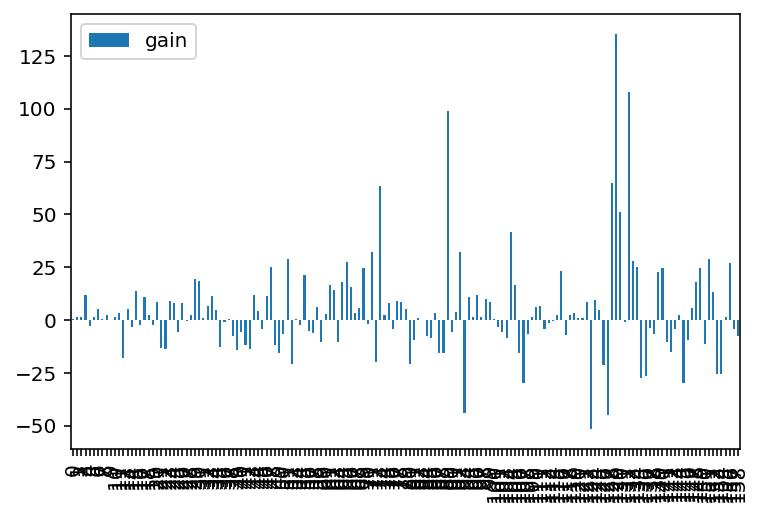

##############################
########## FACEBOOK ##########
##############################



<Figure size 2160x720 with 0 Axes>

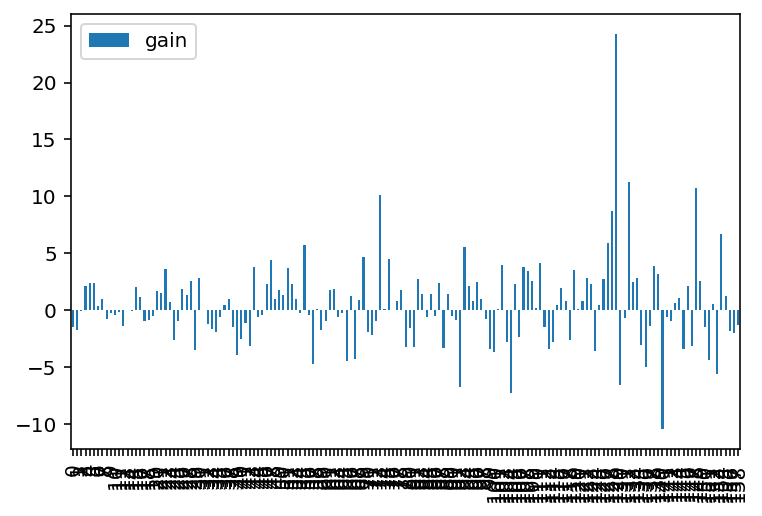

############################
########## AMAZON ##########
############################



<Figure size 2160x720 with 0 Axes>

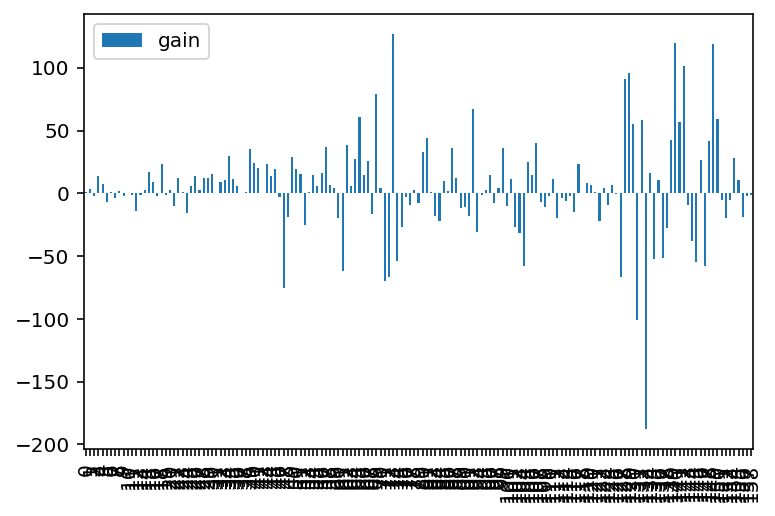

###########################
########## APPLE ##########
###########################



<Figure size 2160x720 with 0 Axes>

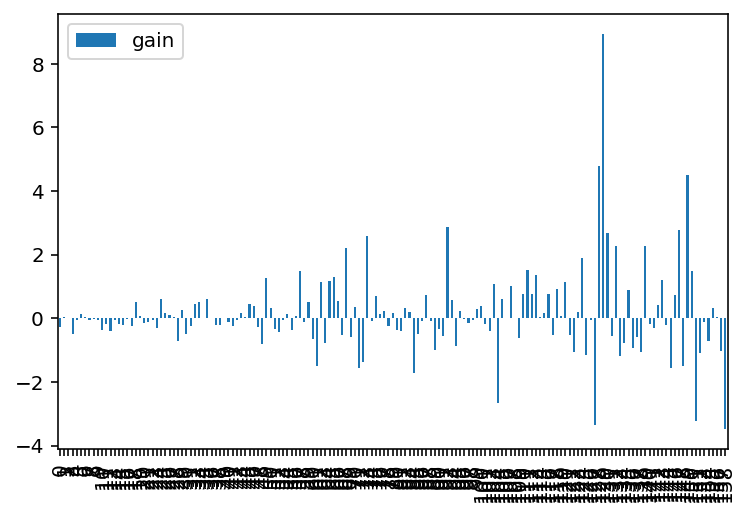

###########################
########## TESLA ##########
###########################



<Figure size 2160x720 with 0 Axes>

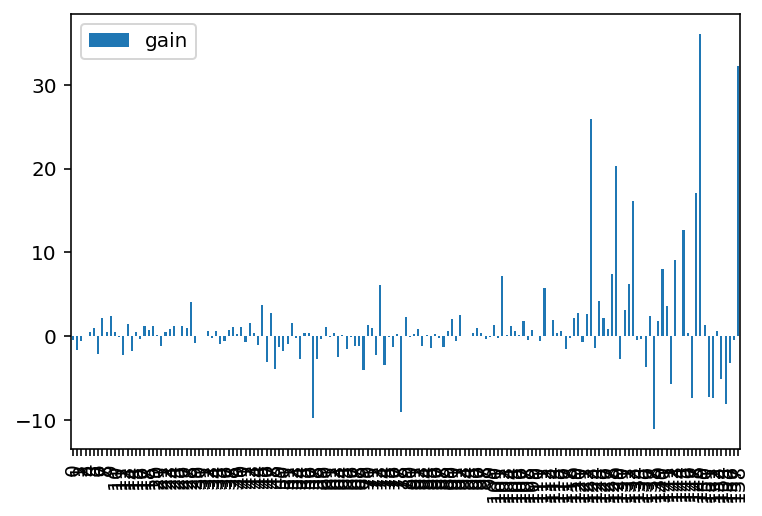

###############################
########## MICROSOFT ##########
###############################



<Figure size 2160x720 with 0 Axes>

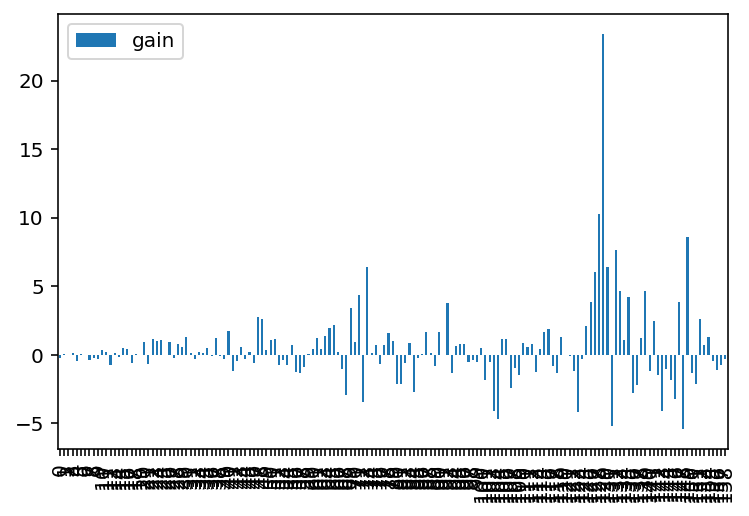

##########################
########## ZOOM ##########
##########################



<Figure size 2160x720 with 0 Axes>

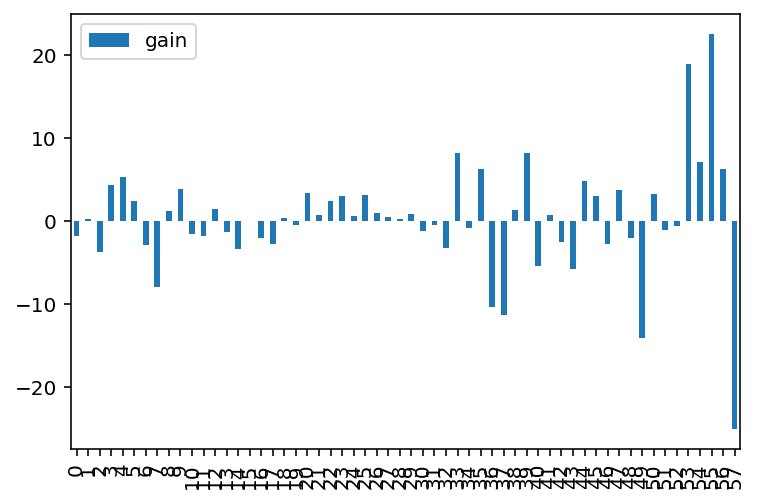

In [12]:
stocks.call_prediction_function("plot_gain_predict")

### Print how much we made:

In [13]:
stocks.call_prediction_function("print_stonks_or_not")

############################
########## GOOGLE ##########
############################

With an initial buy at 806.1500244140625$ we won 636.5150146484375$
##############################
########## FACEBOOK ##########
##############################

With an initial buy at 123.41000366210938$ we won 65.08991241455078$
############################
########## AMAZON ##########
############################

With an initial buy at 795.989990234375$ we won 693.3997802734375$
###########################
########## APPLE ##########
###########################

With an initial buy at 29.477500915527344$ we won 19.857498168945312$
###########################
########## TESLA ##########
###########################

With an initial buy at 45.801998138427734$ we won 156.17198944091797$
###############################
########## MICROSOFT ##########
###############################

With an initial buy at 62.84000015258789$ we won 75.46005249023438$
##########################
########## ZOOM ########